# Field-level Multi-spectral Indices Timeseries

This notebook demonstrates how to measure the evolution of several spectral indices for a specific crop field across one year.



### Micromamba environment setup
To install the required packages, see [this README file](../README.md). You can activate the environment with the following command:


```bash
$ micromamba activate farmvibes-ai
```

### Imports & Setup

In [1]:
import os
from datetime import datetime

import geopandas as gpd
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import rasterio
import yaml
from IPython.core.display import Image
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import DataVibe, ExternalReferenceList, gen_guid
from vibe_notebook.plot import lw_plot, transparent_cmap
from vibe_notebook.raster import read_clip_index, read_raster, s2_to_img, spaceeye_to_img
from vibe_notebook.utils import create_geojson_file_from_point

# Detecting storage directory
config_dir = os.environ.get("XDG_CONFIG_HOME", os.path.expanduser("~/.config"))
storage_config_path = os.path.join(config_dir, "farmvibes-ai", "storage")
with open(storage_config_path) as f:
    storage_dir = f.read().strip()
print(f"Cache directory set to '{storage_dir}' by reading '{storage_config_path}'")

Cache directory set to '/datadrive' by reading '/home/azureuser/.config/farmvibes-ai/storage'


### Downloading Sentinel-2 data and segmenting crop fields

Let's instantiate our client and define a geometry and time range of interest for our analysis:


In [2]:
client = get_default_vibe_client()
geom = shpg.Point(-119.11885352165385, 46.434979211782355).buffer(0.01, cap_style=3)
time_range = (datetime(2020, 1, 1), datetime(2021, 1, 1))

With those defined, we will download Sentinel-2 data:

In [3]:
# Run the Sentinel-2 download workflow
s2_run = client.run(
    "data_ingestion/sentinel2/preprocess_s2_improved_masks",
    "Sentinel 2 - Download",
    geometry=geom,
    time_range=time_range,
)
s2_run.monitor()

Output()

Let's visualize the downloaded raster. For this particular analysis, let's say we are interested in the field in the center of the image:

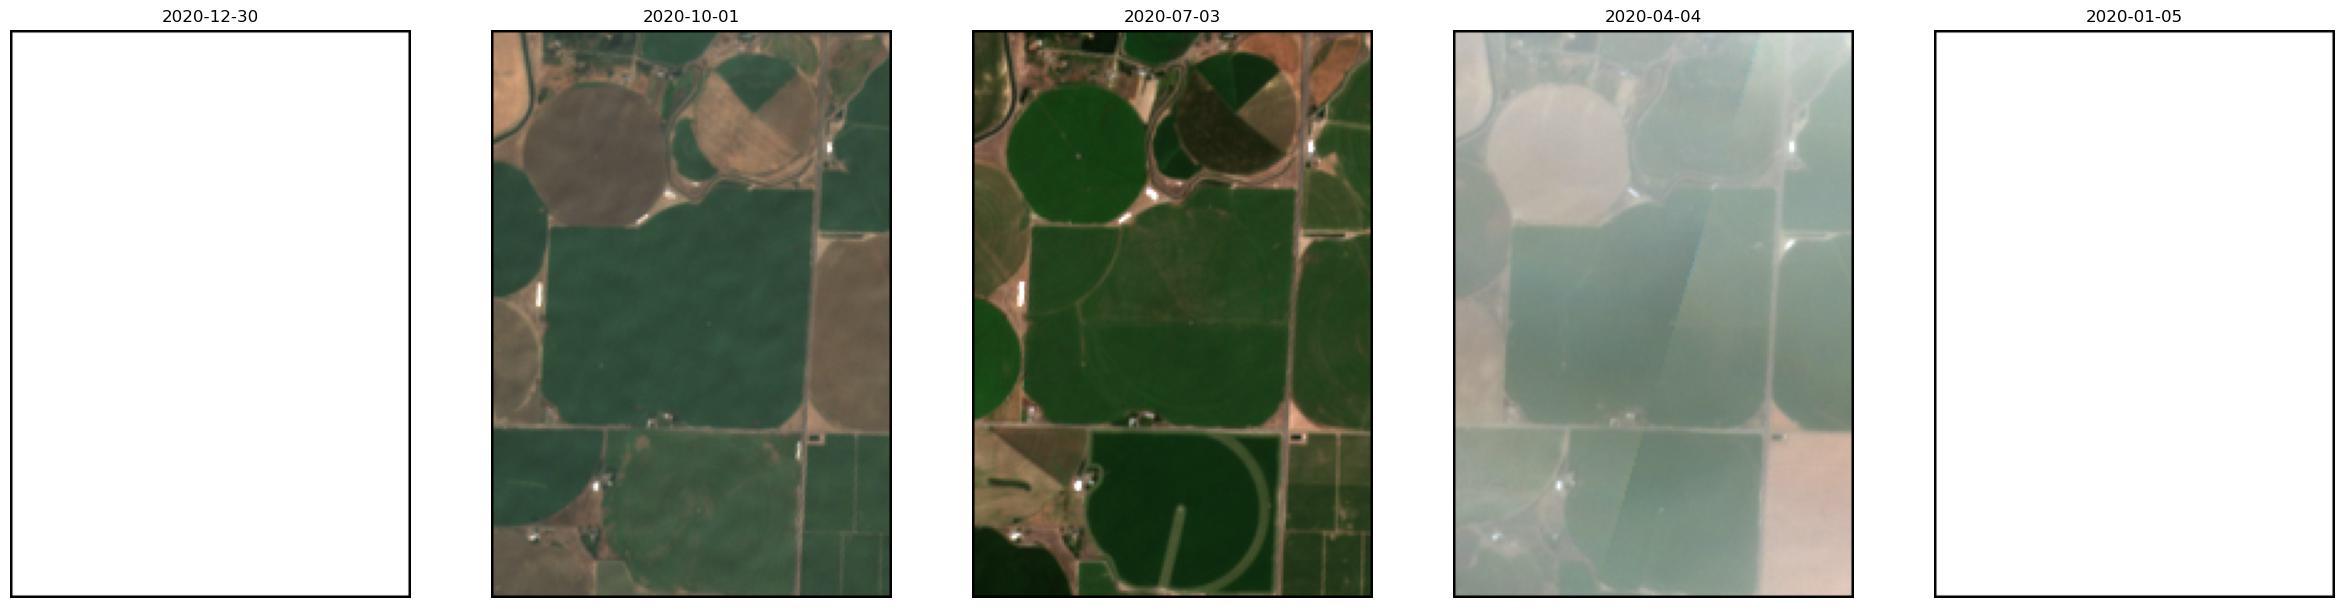

In [4]:
idx_list = np.linspace(0, len(s2_run.output["raster"]) - 1, num=5, dtype=int)

plt.figure(figsize=(30, 10))

for plot_idx, raster_idx in enumerate(idx_list):
    raster = s2_run.output["raster"][raster_idx]
    plt.subplot(1, len(idx_list), plot_idx + 1)
    plt.imshow(s2_to_img(read_raster(raster, geom)[0]))
    plt.title(raster.time_range[0].strftime("%Y-%m-%d"))
    plt.axis("off")

lw_plot()

As we see above, some of the rasters may be covered quite extensivelly by clouds, which would hinder the quality of our segmentation. Let's selected cloud-free rasters to segmentation the field:

In [5]:
# Selecting rasters with less than 10% of cloudy pixels
cloud_thr = 0.1
cloud_ratio = [read_raster(c, geom, filled=False)[0].mean() for c in s2_run.output["mask"]]
cloud_free_rasters = [s2 for s2, c in zip(s2_run.output["raster"], cloud_ratio) if c < cloud_thr]

print(
    f"Selected {len(cloud_free_rasters)} rasters out of {len(s2_run.output['raster'])} with less than {cloud_thr*100}% of cloudy pixels"
)

Selected 31 rasters out of 73 with less than 10.0% of cloudy pixels


We will use a few points in the field as prompts for our segmentation:

In [6]:
# Lat-lon coordinates for those points
point_list = [shpg.Point(geom.centroid.coords[0])]
prompt_ids = [0]
labels = [1]

# Instantiate a geojson with the points to be used for FarmVibes.AI
filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
    id=f"geo_{gen_guid()}",
    time_range=time_range,
    geometry=shpg.mapping(geom),
    assets=[],
    urls=[filepath],
)

# Instantiate the workflow run
roi_time_range = DataVibe(
    id=f"roi_{fid}", time_range=time_range, geometry=shpg.mapping(geom), assets=[]
)

# Run SAM for a few raster
sam_run_list = []
idx_list = np.linspace(0, len(cloud_free_rasters) - 1, num=10, dtype=int)
for raster_idx in idx_list:
    run = client.run(
        "ml/segment_anything/s2_prompt_segmentation",
        f"SAM - Raster {raster_idx}",
        input_data={
            "input_raster": cloud_free_rasters[raster_idx],
            "input_geometry": roi_time_range,
            "input_prompts": geom_collection,
        },
    )
    sam_run_list.append(run)
client.monitor(sam_run_list)

/home/azureuser/anaconda3/envs/segment_anything/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Output()

For a stable segmentation mask, we will combine the masks obtained for each input raster:

In [7]:
combined_mask = read_raster(sam_run_list[0].output["segmentation_mask"][0], geom)[0]
for i in range(1, len(sam_run_list)):
    mask = read_raster(sam_run_list[i].output["segmentation_mask"][0], geom)[0]
    combined_mask = combined_mask * mask[0]
combined_mask = np.where(combined_mask == 0, np.nan, combined_mask)[0]

Visualizing the combined mask:

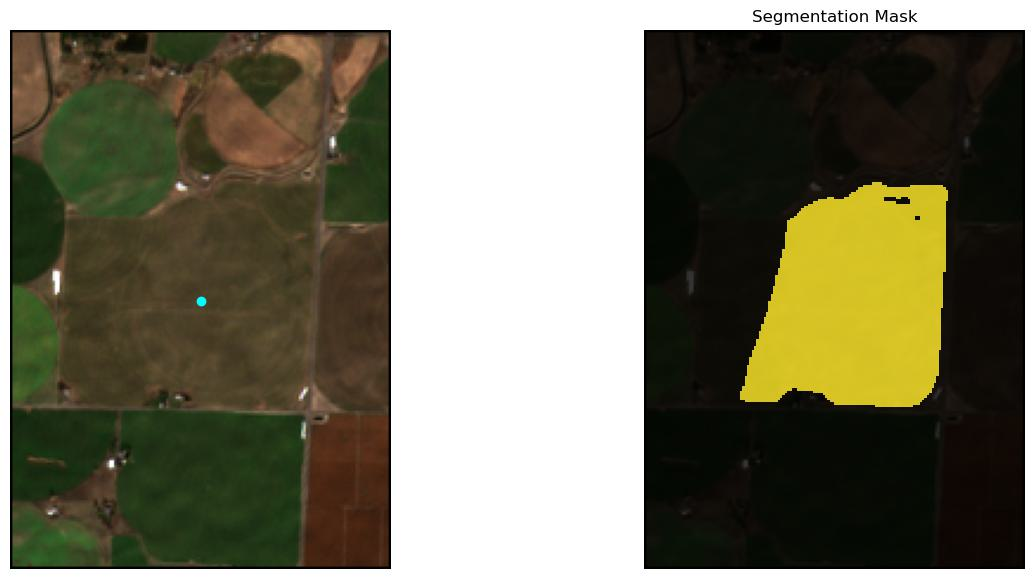

In [8]:
# Reprojecting the raster and points to the same CRS
with rasterio.open(raster.raster_asset.url) as src:
    raster_crs = src.crs
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(raster_crs).iloc[0].envelope
    shpg_points = list(gdf.to_crs(src.crs)["geometry"])


ar, transform = read_raster(cloud_free_rasters[0], projected_geometry=proj_geom)
img = s2_to_img(ar)


# Transforming the points to pixel coordinates for visualization
ps = [~transform * (shpg_p.x, shpg_p.y) for shpg_p in shpg_points]

# Visualizing the results
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.scatter([p[0] for p in ps], [p[1] for p in ps], color="cyan")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(combined_mask, cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
plt.title("Segmentation Mask")
plt.axis("off")
lw_plot()

### Computing NDVI and LSWI using cloud-free data from SpaceEye

As we've seen, the cloud coverage in the downloaded Sentinel-2 data is quite high. We will use SpaceEye to generate cloud-free data for the desired field this region and time range.

We will, then, use the cloud-free data to compute NDVI and LSWI indices:

In [9]:
wf_dict = yaml.safe_load(open("./spaceeye_index.yaml"))

index_run_dict = {}
index_name_list = ["ndvi", "lswi"]

for index_name in index_name_list:
    run = client.run(
        wf_dict,
        f"{index_name}",
        geometry=geom,
        time_range=(
            datetime(2020, 4, 1),
            datetime(2020, 10, 1),
        ),  # Running for the crop season interval
        parameters={"index": index_name},
    )
    index_run_dict[index_name] = run
    run.monitor()

Output()

Output()

We will obtain the masked index raster for the segmented region using `combined_mask` and then calculate the average NDVI and LSWI across each collection in our time range:

In [10]:
masked_dict, avg_dict = {}, {}
for index_name in index_name_list:
    masked_dict[index_name] = []
    avg_dict[index_name] = []
    dates = []
    for i in range(len(index_run_dict[index_name].output["index"])):
        ar = read_clip_index(index_run_dict[index_name].output["index"][i], geom)
        masked_index = ar * combined_mask

        # Check if the raster is empty
        if not np.isnan(masked_index).all():
            masked_dict[index_name].append(masked_index)
            avg_dict[index_name].append(np.nanmean(masked_index))
            dates.append(
                index_run_dict[index_name].output["index"][i].time_range[0].strftime("%Y-%m-%d")
            )

For visualization, we can build a timelapse with the SpaceEye and index rasters:

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


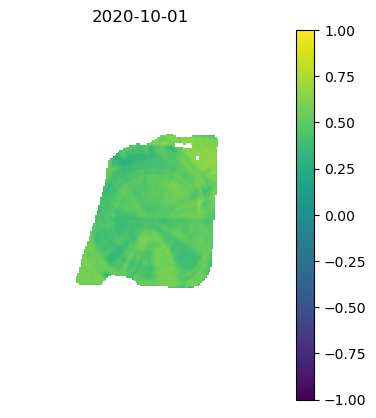

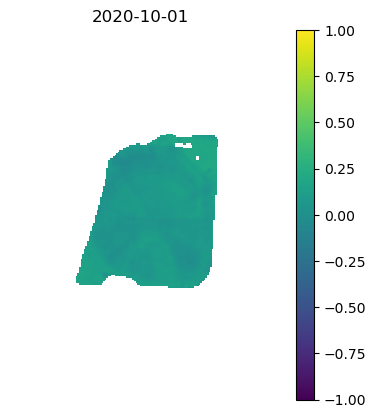

In [11]:
for index_name in index_name_list:
    # Set up the figure and axis
    fig, ax = plt.subplots()

    # Initialize the image plot
    im = ax.imshow(masked_dict[index_name][0], cmap="viridis", vmin=-1, vmax=1)
    ax.set_title(f"{dates[0]}")
    cbar = fig.colorbar(im, ax=ax)
    ax.axis("off")

    # Function to update the plot for each frame
    def update(i):
        im.set_array(masked_dict[index_name][i])
        ax.set_title(f"{dates[i]}")
        return (im,)

    # Set up the animation using the update function
    ani = animation.FuncAnimation(fig, update, frames=range(len(dates)), blit=True, interval=0.33)

    # Save the animation as a GIF
    ani.save(f"timelapse_{index_name}.gif", writer="imagemagick")

MovieWriter imagemagick unavailable; using Pillow instead.


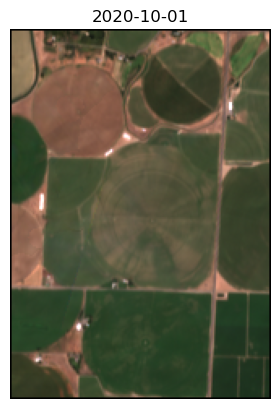

In [12]:
run = index_run_dict["ndvi"]
fig, ax = plt.subplots()

# Initialize the image plot
im = ax.imshow(
    spaceeye_to_img(read_raster(run.output["spaceeye_raster"][0], projected_geometry=proj_geom)[0])
)
ax.set_title(f"{run.output['spaceeye_raster'][0].time_range[0].strftime('%Y-%m-%d')}")
ax.axis("off")


# Function to update the plot for each frame
def update(i):
    im.set_array(
        spaceeye_to_img(
            read_raster(run.output["spaceeye_raster"][i], projected_geometry=proj_geom)[0]
        )
    )
    ax.set_title(f"{run.output['spaceeye_raster'][i].time_range[0].strftime('%Y-%m-%d')}")
    return (im,)


# Set up the animation using the update function
ani = animation.FuncAnimation(
    fig, update, frames=range(len(run.output["spaceeye_raster"])), blit=True, interval=0.33
)

# Save the animation as a GIF
ani.save("timelapse_spaceeye.gif", writer="imagemagick")

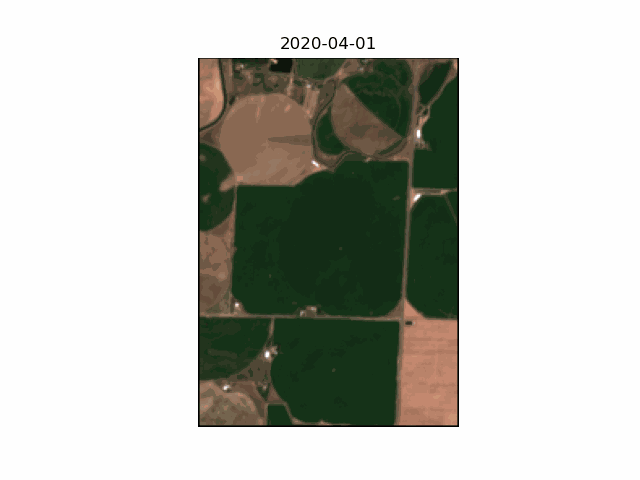

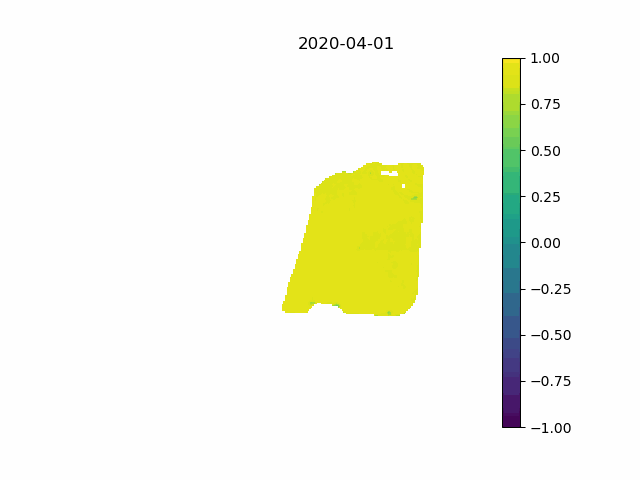

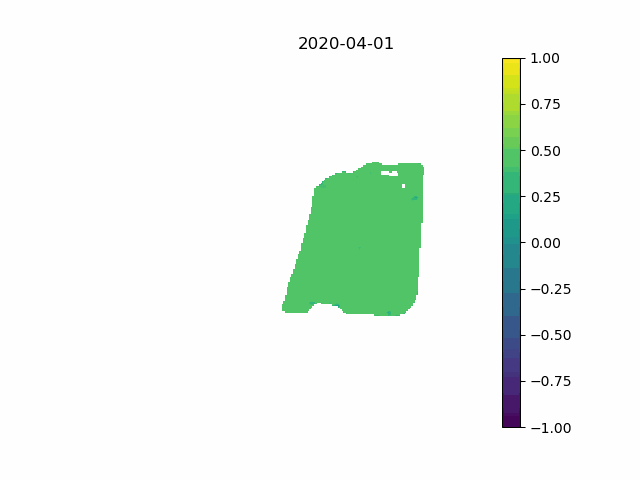

In [13]:
# Display the animation
display(Image(filename="./timelapse_spaceeye.gif"))
display(Image(filename="./timelapse_ndvi.gif"))
display(Image(filename="./timelapse_lswi.gif"))

We can also plot the field-level average NDVI and LSWI across time:

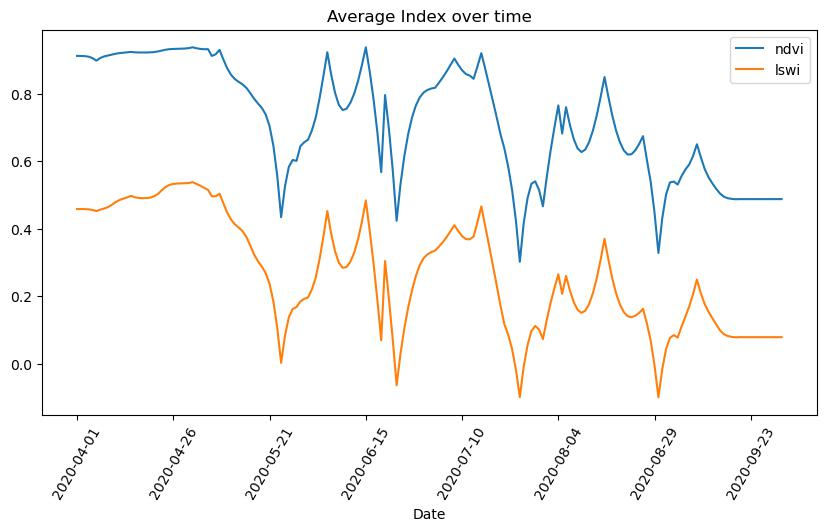

In [14]:
# Plot the average NDVI over time
plt.figure(figsize=(10, 5))
for index_name in index_name_list:
    plt.plot(dates, avg_dict[index_name], label=index_name)
plt.legend(index_name_list)
plt.title("Average Index over time")
plt.xlabel("Date")

plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.xticks(rotation=60)
lw_plot()